In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
print(sys.executable)


C:\Users\PC\Desktop\ml_project\venv\Scripts\python.exe


In [3]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14', 'RSI_30',
       'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change',
       'Log_Returns', 'Volatility_10', 'Volatility_30', 'Future_Close',
       'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [4]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [5]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [6]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [8]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8748, 15)
y_train shape: (8748,)


## LightGboost

In [9]:
from lightgbm import LGBMClassifier
from sklearn.base import is_classifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

True


In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss 
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Num

Cross-Validation Binary Logloss: 0.4189880649577101
[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Accuracy on Test Data: 0.8080438756855576


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Hyperparameter

In [11]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191


Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Best Score: 0.8388206158621253


##  Rebuild the model with Hyperparameters 

In [12]:
# Train the model with the best parameters
LightGBM = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
LightGBM.fit(X_train_scaled, y_train)

# Make predictions
y_pred = LightGBM.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191


Accuracy on Test Data with Tuned Parameters: 0.8496343692870201


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


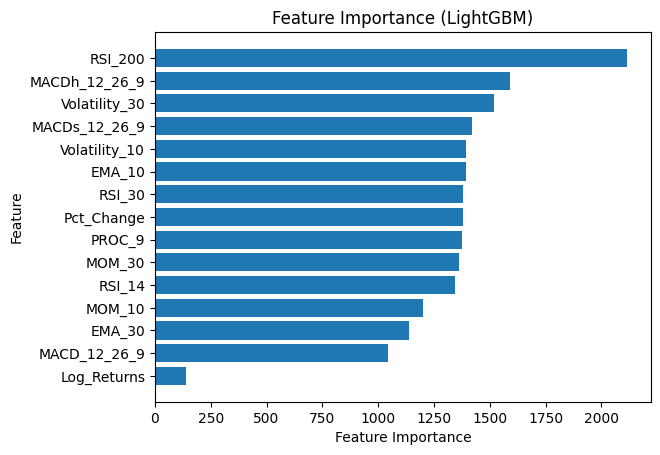

In [13]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = LightGBM.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


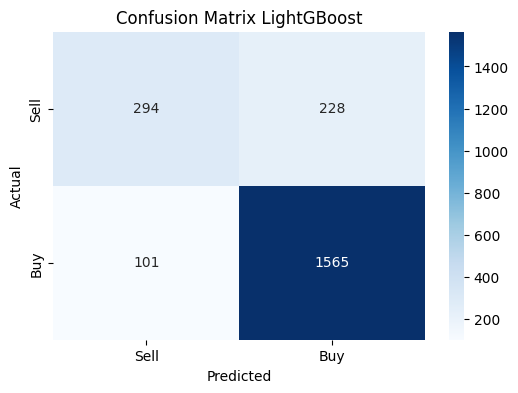

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix as a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 294                 228
Actual Positive                 101                1565


In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 84.96%

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.56      0.64       522
           1       0.87      0.94      0.90      1666

    accuracy                           0.85      2188
   macro avg       0.81      0.75      0.77      2188
weighted avg       0.84      0.85      0.84      2188



In [17]:
# Assuming the test set represents the latest data points
start_index = len(data) - len(y_test)  # Find where the test set starts
date_range = pd.date_range(start='2024-01-01', periods=len(y_test), freq='D')  # Generate artificial dates

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'date': date_range,  # Using a fake date range (adjust as needed)
    'actual_price': y_test.values,  # If y_test is classification, replace with actual close price
    'predicted_price': y_pred,
    'decision': ['BUY' if pred == 1 else 'SELL' for pred in y_pred],
    'confidence': LightGBM.predict_proba(X_test_scaled)[:, 1]  # Probability of "BUY"
})


# Save to CSV
predictions_df.to_csv("C:/Users/PC/Desktop/ml_project/Algorithm_Trading_ML/data/final_predictions.csv", index=False)

print("Predictions saved successfully!")


Predictions saved successfully!


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [18]:
predictions_df

,date,actual_price,predicted_price,decision,confidence
0,2024-01-01,1,1,BUY,0.999941
1,2024-01-02,1,1,BUY,0.873055
2,2024-01-03,0,1,BUY,0.912511
3,2024-01-04,1,1,BUY,0.999962
4,2024-01-05,0,1,BUY,0.945906
...,...,...,...,...,...
2183,2029-12-23,1,0,SELL,0.211570
2184,2029-12-24,0,0,SELL,0.007840
2185,2029-12-25,1,1,BUY,0.997334
2186,2029-12-26,1,1,BUY,0.980576


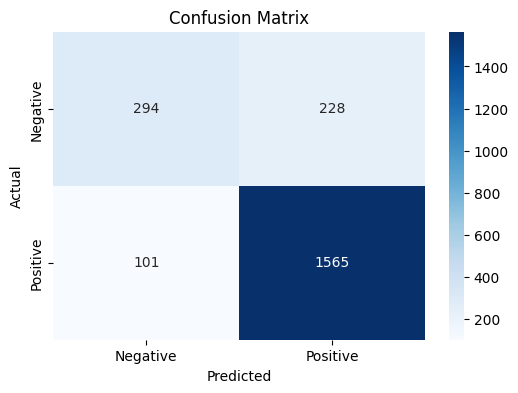

In [19]:
# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 2. XGBoost Model


In [20]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


In [21]:
# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


In [22]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


In [25]:
# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50) 

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-25 19:47:40,604] A new study created in memory with name: XGBoost Hyperparameter Tuning


[I 2025-02-25 19:47:43,429] Trial 0 finished with value: 0.46127780877429314 and parameters: {'booster': 'gbtree', 'eta': 0.013130191450879895, 'max_depth': 4, 'min_child_weight': 1.871813995991841, 'subsample': 0.8787166679248606, 'colsample_bytree': 0.6986194066877006, 'lambda': 0.048688911050164284, 'alpha': 5.859075177665991}. Best is trial 0 with value: 0.46127780877429314.


[I 2025-02-25 19:48:23,307] Trial 1 finished with value: 0.4241049553602152 and parameters: {'booster': 'dart', 'eta': 0.03861054264706316, 'max_depth': 7, 'min_child_weight': 1.5178608645026712, 'subsample': 0.6987943766879915, 'colsample_bytree': 0.8206614858867791, 'lambda': 1.1980208496747013, 'alpha': 2.4638900331786955}. Best is trial 1 with value: 0.4241049553602152.


[I 2025-02-25 19:49:07,022] Trial 2 finished with value: 0.43313430106674816 and parameters: {'booster': 'dart', 'eta': 0.016137067842331803, 'max_depth': 7, 'min_child_weight': 1.1746918810371527, 'subsample': 0.763979018714346, 'colsample_bytree': 0.8163509321923759, 'lambda': 0.06644443359806278, 'alpha': 0.008687636677540828}. Best is trial 1 with value: 0.4241049553602152.


[I 2025-02-25 19:49:39,254] Trial 3 finished with value: 0.4245746761762227 and parameters: {'booster': 'dart', 'eta': 0.06807657409282018, 'max_depth': 6, 'min_child_weight': 5.252962600462067, 'subsample': 0.6861016664371695, 'colsample_bytree': 0.5524520146617522, 'lambda': 0.009288261637915123, 'alpha': 1.40149577764761}. Best is trial 1 with value: 0.4241049553602152.


[I 2025-02-25 19:50:12,192] Trial 4 finished with value: 0.41994174840378207 and parameters: {'booster': 'dart', 'eta': 0.13154591221076314, 'max_depth': 7, 'min_child_weight': 8.774957977078685, 'subsample': 0.8052327607774605, 'colsample_bytree': 0.5725081066050075, 'lambda': 2.613001810389842, 'alpha': 0.002877245102430072}. Best is trial 4 with value: 0.41994174840378207.


[I 2025-02-25 19:50:15,943] Trial 5 finished with value: 0.41846219059286655 and parameters: {'booster': 'gbtree', 'eta': 0.02896520743827094, 'max_depth': 8, 'min_child_weight': 2.02216493429682, 'subsample': 0.8508402840070279, 'colsample_bytree': 0.6433040047157779, 'lambda': 1.6258216871125224, 'alpha': 0.020392557620285415}. Best is trial 5 with value: 0.41846219059286655.


[I 2025-02-25 19:50:42,947] Trial 6 finished with value: 0.43815907219856537 and parameters: {'booster': 'dart', 'eta': 0.09574923517262092, 'max_depth': 3, 'min_child_weight': 3.301671834738672, 'subsample': 0.9259426266134647, 'colsample_bytree': 0.8397158098441588, 'lambda': 0.019195645518043505, 'alpha': 0.0027926709847947455}. Best is trial 5 with value: 0.41846219059286655.


[I 2025-02-25 19:50:45,778] Trial 7 finished with value: 0.45274485441429074 and parameters: {'booster': 'gbtree', 'eta': 0.012420343896321554, 'max_depth': 6, 'min_child_weight': 1.9348321297145377, 'subsample': 0.99236890942934, 'colsample_bytree': 0.6112148045816447, 'lambda': 1.1772369862810022, 'alpha': 0.006336386861621226}. Best is trial 5 with value: 0.41846219059286655.


[I 2025-02-25 19:51:19,314] Trial 8 finished with value: 0.4143152351222367 and parameters: {'booster': 'dart', 'eta': 0.14505191058600508, 'max_depth': 7, 'min_child_weight': 7.639834816412808, 'subsample': 0.8042984906722912, 'colsample_bytree': 0.994182519399766, 'lambda': 0.01818427102979154, 'alpha': 0.7563622697449317}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:51:54,121] Trial 9 finished with value: 0.4378488988503452 and parameters: {'booster': 'dart', 'eta': 0.013225066725710584, 'max_depth': 8, 'min_child_weight': 1.3548847962930783, 'subsample': 0.8210776241597928, 'colsample_bytree': 0.6655490148052607, 'lambda': 0.01027954412755945, 'alpha': 0.16026798667974}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:51:55,607] Trial 10 finished with value: 0.4398992523329811 and parameters: {'booster': 'gbtree', 'eta': 0.2647186752228428, 'max_depth': 10, 'min_child_weight': 9.67292258475857, 'subsample': 0.5275109361539436, 'colsample_bytree': 0.9883840110814941, 'lambda': 0.0020091212707379538, 'alpha': 0.28503898952430756}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:51:59,883] Trial 11 finished with value: 0.4256635420993802 and parameters: {'booster': 'gbtree', 'eta': 0.03393148835176599, 'max_depth': 9, 'min_child_weight': 2.990756334148995, 'subsample': 0.6297066946036363, 'colsample_bytree': 0.9328005514352489, 'lambda': 9.763691041191581, 'alpha': 0.04785674178106046}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:52:02,132] Trial 12 finished with value: 0.4228728743837463 and parameters: {'booster': 'gbtree', 'eta': 0.20547028136603626, 'max_depth': 5, 'min_child_weight': 4.993077906315227, 'subsample': 0.880060178506214, 'colsample_bytree': 0.504961822559838, 'lambda': 0.26648403785543034, 'alpha': 0.03557500733352778}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:52:06,710] Trial 13 finished with value: 0.4148675517704069 and parameters: {'booster': 'gbtree', 'eta': 0.026548754935124524, 'max_depth': 9, 'min_child_weight': 2.888930083104217, 'subsample': 0.835015500973587, 'colsample_bytree': 0.7320871124054771, 'lambda': 0.29322218637568326, 'alpha': 0.5814778625058536}. Best is trial 8 with value: 0.4143152351222367.


[I 2025-02-25 19:52:42,323] Trial 14 finished with value: 0.4098773823167979 and parameters: {'booster': 'dart', 'eta': 0.06224321769252668, 'max_depth': 10, 'min_child_weight': 6.050536549599058, 'subsample': 0.7612026010485675, 'colsample_bytree': 0.7594676715003428, 'lambda': 0.21169330432972597, 'alpha': 0.48742757548708276}. Best is trial 14 with value: 0.4098773823167979.


[I 2025-02-25 19:53:31,281] Trial 15 finished with value: 0.4091979872196433 and parameters: {'booster': 'dart', 'eta': 0.13282026511390865, 'max_depth': 10, 'min_child_weight': 6.478800084968612, 'subsample': 0.7263887561815949, 'colsample_bytree': 0.9494944711282078, 'lambda': 0.0015360524434240934, 'alpha': 0.6823020492921708}. Best is trial 15 with value: 0.4091979872196433.


[I 2025-02-25 19:54:16,715] Trial 16 finished with value: 0.42431374910980074 and parameters: {'booster': 'dart', 'eta': 0.06020703495119475, 'max_depth': 10, 'min_child_weight': 6.101393362651351, 'subsample': 0.597562312839858, 'colsample_bytree': 0.8927760852755449, 'lambda': 0.0017333388396360153, 'alpha': 4.778054151218315}. Best is trial 15 with value: 0.4091979872196433.


[I 2025-02-25 19:55:15,706] Trial 17 finished with value: 0.4011869766136787 and parameters: {'booster': 'dart', 'eta': 0.0956487228992213, 'max_depth': 10, 'min_child_weight': 4.175163959799991, 'subsample': 0.7344423691861822, 'colsample_bytree': 0.7701635493977851, 'lambda': 0.1957131988293901, 'alpha': 0.17595121929605434}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 19:56:01,274] Trial 18 finished with value: 0.40572402354426196 and parameters: {'booster': 'dart', 'eta': 0.11187350316133224, 'max_depth': 9, 'min_child_weight': 4.067234906374993, 'subsample': 0.7083404392326291, 'colsample_bytree': 0.8977583923770184, 'lambda': 0.0041637414010242705, 'alpha': 0.10178134693609076}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 19:56:37,070] Trial 19 finished with value: 0.40583463156894223 and parameters: {'booster': 'dart', 'eta': 0.08969030948419364, 'max_depth': 9, 'min_child_weight': 3.941409990279377, 'subsample': 0.6513836655601438, 'colsample_bytree': 0.8776316933179006, 'lambda': 0.004082729119849917, 'alpha': 0.14305948304569396}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 19:56:52,720] Trial 20 finished with value: 0.4184782181098437 and parameters: {'booster': 'dart', 'eta': 0.17225387529789477, 'max_depth': 8, 'min_child_weight': 4.015349986780273, 'subsample': 0.5664511652510577, 'colsample_bytree': 0.7792010494027733, 'lambda': 0.15648149844783676, 'alpha': 0.05985081806612704}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 19:57:26,745] Trial 21 finished with value: 0.4029708885935851 and parameters: {'booster': 'dart', 'eta': 0.09917463134985802, 'max_depth': 9, 'min_child_weight': 3.922460212441424, 'subsample': 0.6507828971498818, 'colsample_bytree': 0.8814229335690775, 'lambda': 0.005409658063920989, 'alpha': 0.15270382472732946}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 19:59:05,849] Trial 22 finished with value: 0.4055663247227752 and parameters: {'booster': 'dart', 'eta': 0.09945290392587045, 'max_depth': 9, 'min_child_weight': 4.201056421448852, 'subsample': 0.6998898128086471, 'colsample_bytree': 0.8919595368608721, 'lambda': 0.004649022540755738, 'alpha': 0.13668220562170694}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 20:01:19,590] Trial 23 finished with value: 0.4089054993677693 and parameters: {'booster': 'dart', 'eta': 0.08780411144388611, 'max_depth': 9, 'min_child_weight': 4.697351005502645, 'subsample': 0.676810261842207, 'colsample_bytree': 0.8638754217048032, 'lambda': 0.03166112026512403, 'alpha': 0.2594876499112975}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 20:04:12,105] Trial 24 finished with value: 0.4124244521227717 and parameters: {'booster': 'dart', 'eta': 0.04663527875309079, 'max_depth': 8, 'min_child_weight': 2.5366718452730503, 'subsample': 0.6082392480280514, 'colsample_bytree': 0.9275548880976476, 'lambda': 0.5632006330581837, 'alpha': 0.01971985049443846}. Best is trial 17 with value: 0.4011869766136787.


[I 2025-02-25 20:08:59,317] Trial 25 finished with value: 0.3942553567988318 and parameters: {'booster': 'dart', 'eta': 0.08031820979400946, 'max_depth': 10, 'min_child_weight': 2.5326108316047464, 'subsample': 0.7606249088595807, 'colsample_bytree': 0.7835600567389827, 'lambda': 0.005173954372879791, 'alpha': 0.07478366731193475}. Best is trial 25 with value: 0.3942553567988318.


[I 2025-02-25 20:10:50,329] Trial 26 finished with value: 0.39466892431961653 and parameters: {'booster': 'dart', 'eta': 0.07999786730324321, 'max_depth': 10, 'min_child_weight': 2.4956854889417883, 'subsample': 0.7652220068089604, 'colsample_bytree': 0.7923369183001412, 'lambda': 0.07218984371832085, 'alpha': 0.06149639543314354}. Best is trial 25 with value: 0.3942553567988318.


[I 2025-02-25 20:11:19,439] Trial 27 finished with value: 0.396021219588839 and parameters: {'booster': 'dart', 'eta': 0.04786142695196583, 'max_depth': 10, 'min_child_weight': 2.4307828107940157, 'subsample': 0.7713673574131289, 'colsample_bytree': 0.784060862800444, 'lambda': 0.09879471874022881, 'alpha': 0.022426763270848842}. Best is trial 25 with value: 0.3942553567988318.


[I 2025-02-25 20:11:48,309] Trial 28 finished with value: 0.3969093488464198 and parameters: {'booster': 'dart', 'eta': 0.04429771522000745, 'max_depth': 10, 'min_child_weight': 2.3631480271117296, 'subsample': 0.7750187934088892, 'colsample_bytree': 0.7084236535034962, 'lambda': 0.07149827677862487, 'alpha': 0.018129343214795573}. Best is trial 25 with value: 0.3942553567988318.


[I 2025-02-25 20:12:12,711] Trial 29 finished with value: 0.4447818244186741 and parameters: {'booster': 'dart', 'eta': 0.02182709930239009, 'max_depth': 4, 'min_child_weight': 2.1112371147848514, 'subsample': 0.8893133541832053, 'colsample_bytree': 0.7998462030322385, 'lambda': 0.03311516652613178, 'alpha': 0.009908259027085814}. Best is trial 25 with value: 0.3942553567988318.


[I 2025-02-25 20:12:40,642] Trial 30 finished with value: 0.3835311473008097 and parameters: {'booster': 'dart', 'eta': 0.07396369513140245, 'max_depth': 10, 'min_child_weight': 1.4706036917779894, 'subsample': 0.9212233359924485, 'colsample_bytree': 0.717331946898849, 'lambda': 0.0877143897177152, 'alpha': 0.03810988693255423}. Best is trial 30 with value: 0.3835311473008097.


In [ ]:
# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
XGBoost = xgb.XGBClassifier(**best_params, random_state=42)
XGBoost.fit(X_train_scaled, y_train)


In [ ]:
# Step 8: Evaluate the model on the test set
y_pred = XGBoost.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(**params, random_state=42)
    
    # Evaluation 
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss


study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

In [ ]:
from sklearn.ensemble import RandomForestClassifier  

best_params = study.best_params

best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
rf_model = RandomForestClassifier(**best_params)  
rf_model.fit(X_train_scaled, y_train)


In [ ]:
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Final Model (The best Model)

In [ ]:
'''
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) 
at different thresholds showing how well a model can distinguish between two 
classes such as positive and negative outcomes.

'''


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Your trained models
models = [rf_model, LightGBM, XGBoost]  # Update model names accordingly
model_names = ['Random Forest', 'LightGBM', 'XGBoost']

# Placeholder for actual predicted probabilities
model_probabilities = [
    rf_model.predict_proba(X_test_scaled),  # Random Forest
    LightGBM.predict_proba(X_test_scaled),  # LightGBM
    XGBoost.predict_proba(X_test_scaled)    # XGBoost
]

# Prepare a figure for plotting
plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
    # Get the predicted probabilities for the positive class (class 1)
    y_prob = model_probabilities[i][:, 1]  # Assuming it's a binary classification model
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Compute the AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Labels and Title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
# Save the model for future use
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved successfully.")
  


In [ ]:
import joblib

# Save the trained model
joblib.dump(LightGBM, "lightgbm_aapl_model.pkl")

# Load it later for predictions
loaded_model = joblib.load("lightgbm_aapl_model.pkl")
